In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib
import cv2
import torch
from torchvision.transforms import Resize
from losses import get_optimizer
from models.ema import ExponentialMovingAverage
import hydra
from hydra import compose, initialize
import controllable_generation
from precipitation import crop_dataset
from utils import restore_checkpoint
import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import sampling
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor,
                      LangevinCorrector,
                      EulerMaruyamaPredictor,
                      AncestralSamplingPredictor,
                      NoneCorrector,
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets
sns.set(font_scale=2)
sns.set(style="whitegrid")

2023-08-08 17:15:20.770767: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 17:15:20.813679: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 17:15:21.409580: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
def image_grid(x, size=None, config=None):
    # config cannot be none...
    if size is None:
        size = config.data.image_size
    channels = config.data.num_channels
    img = x.reshape(-1, size, size, channels)
    w = int(np.sqrt(img.shape[0]))
    img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
    return img


def show_samples(x, size=None, caption=None, config=None, display=True, save_path=None):
    x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
    img = image_grid(x, size, config)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(img)
    if caption is not None:
        plt.title(caption)
    if display:
        plt.show()
    if save_path is not None:
        plt.savefig(save_path)
    plt.close()

In [4]:
initialize(config_path="../configs", job_name="test_app", version_base=None)
config = compose(config_name="ncsnpp_rainfall")

## Input, output, ground truth

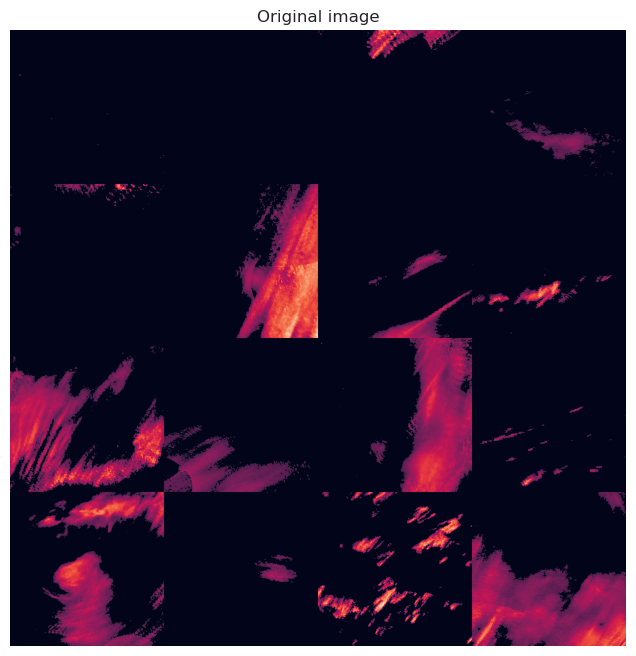

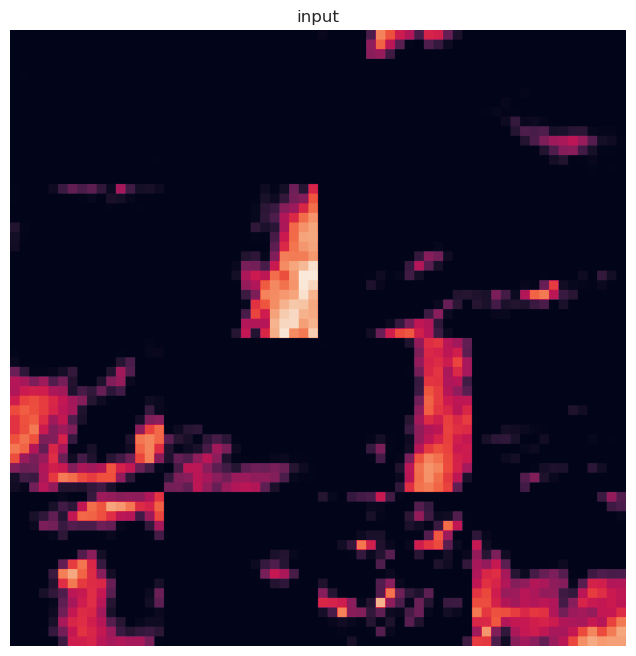

Output()

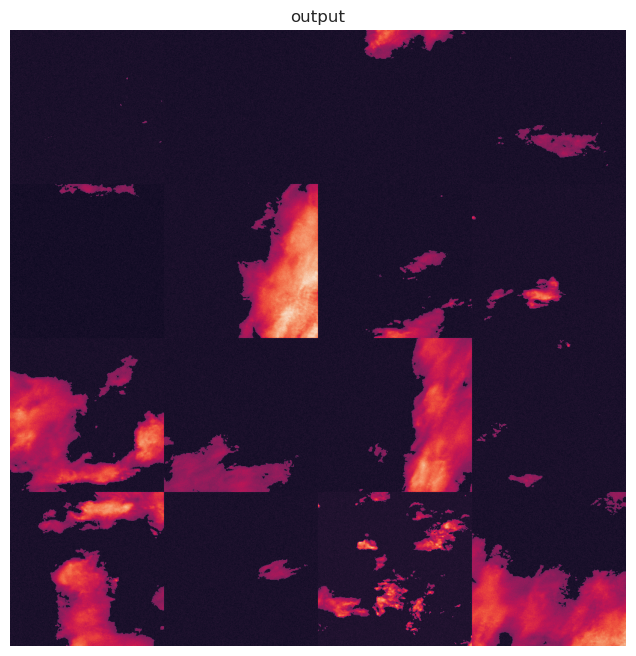

In [5]:
config.training.batch_size = config.data.batch_size
# load score_based models
checkpoint_path = '/home/yl241/models/NCSNPP/wandb/run-20230803_000529-8qmsz4bu/checkpoints/'
sde = 'VESDE'  # @param ['VESDE', 'VPSDE', 'subVPSDE'] {"type": "string"}
if sde.lower() == 'vesde':
    ckpt_filename = checkpoint_path + "checkpoint_16.pth"
    sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
    sampling_eps = 1e-5
elif sde.lower() == 'vpsde':
    raise NotImplementedError()
elif sde.lower() == 'subvpsde':
    raise NotImplementedError()

batch_size = 16  # @param {"type":"integer"}
config.training.batch_size = batch_size
config.eval.batch_size = batch_size
config.data.batch_size = batch_size

random_seed = 0  # @param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

# PC super-resolution
train_ds, eval_ds = crop_dataset.get_rainfall_crop_dataset(config,
                                                           uniform_dequantization=config.data.uniform_dequantization)
eval_iter = iter(eval_ds)
bpds = []

predictor = ReverseDiffusionPredictor  # @param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector  # @param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16  # @param {"type": "number"}
n_steps = 1  # @param {"type": "integer"}
probability_flow = False  # @param {"type": "boolean"}
scale_factor = 0.25

pc_upsampler = controllable_generation.get_pc_upsampler(sde,
                                                        predictor, corrector,
                                                        inverse_scaler,
                                                        snr=snr,
                                                        n_steps=n_steps,
                                                        probability_flow=probability_flow,
                                                        continuous=config.training.continuous,
                                                        denoise=True)
low_res, high_res = next(eval_iter)
low_res, high_res = low_res.to(config.device), high_res.to(config.device)
show_samples(high_res, config=config, caption='Original image')
show_samples(low_res, config=config, caption='input')
x = pc_upsampler(score_model, scaler(low_res))
show_samples(x, config=config, caption='output')

## Does downsampled output match input?

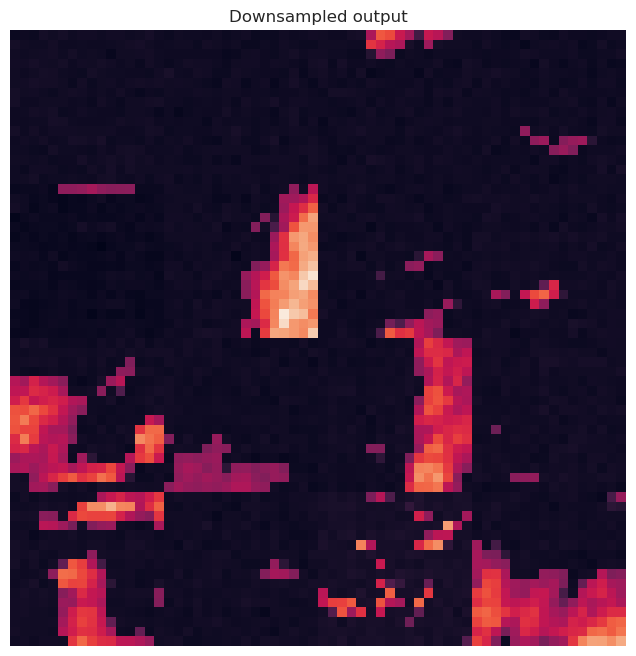

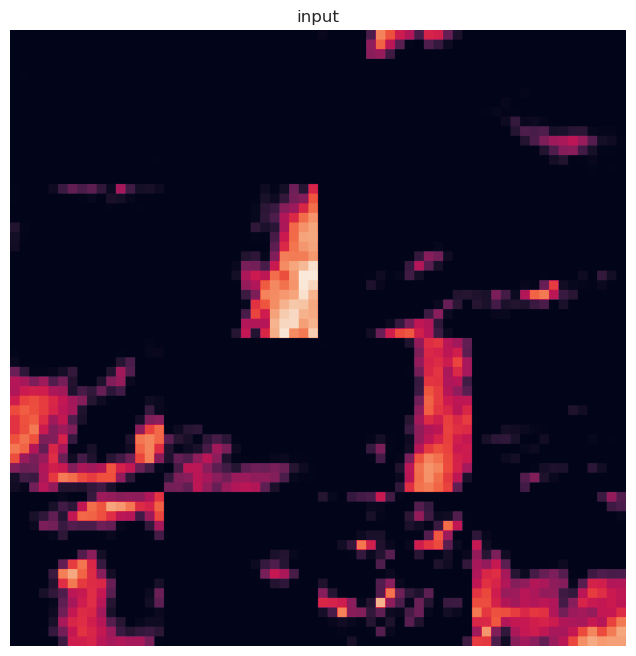

In [7]:
ratio = config.data.resolution_ratio
resize = Resize(size=[int(x.shape[2]/ratio), int(x.shape[3]/ratio)])
ds_output = resize(x)
show_samples(ds_output, config=config, caption='Downsampled output', size=int(x.shape[2]/ratio))
show_samples(low_res, config=config, caption='input')

Observation: downsampled output is noisy, and it looks slightly different from input

## Generate an ensemble of predictions

Output()

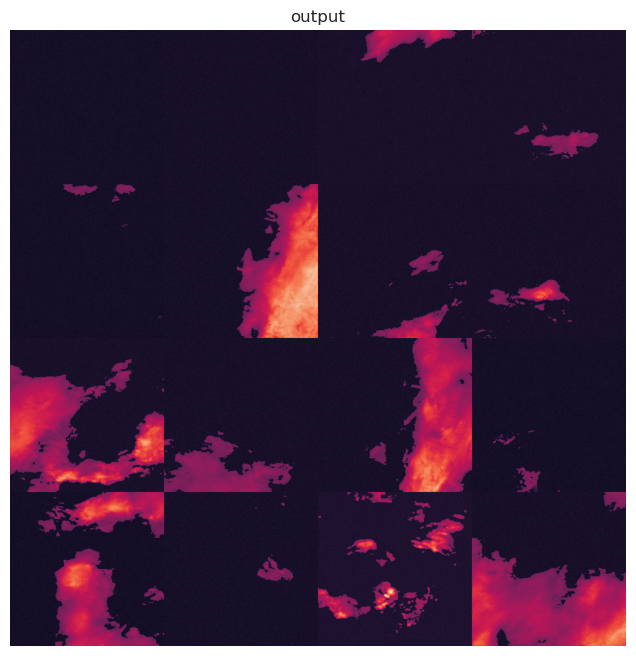

Output()

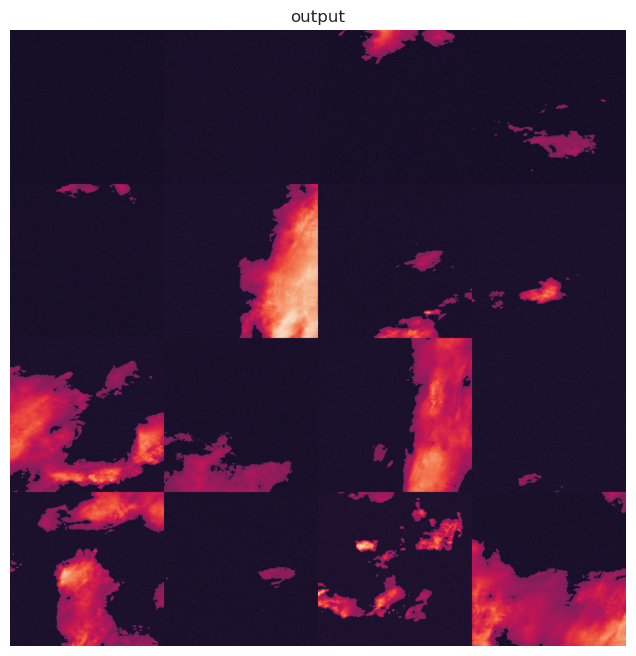

Output()

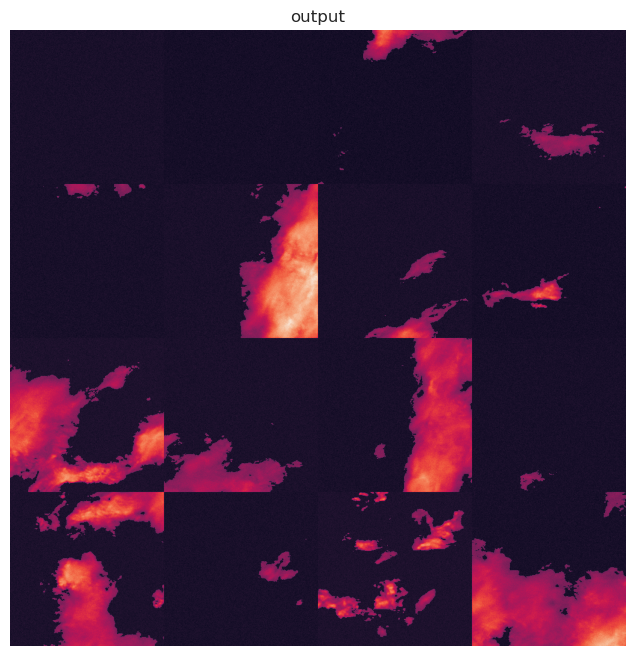

Output()

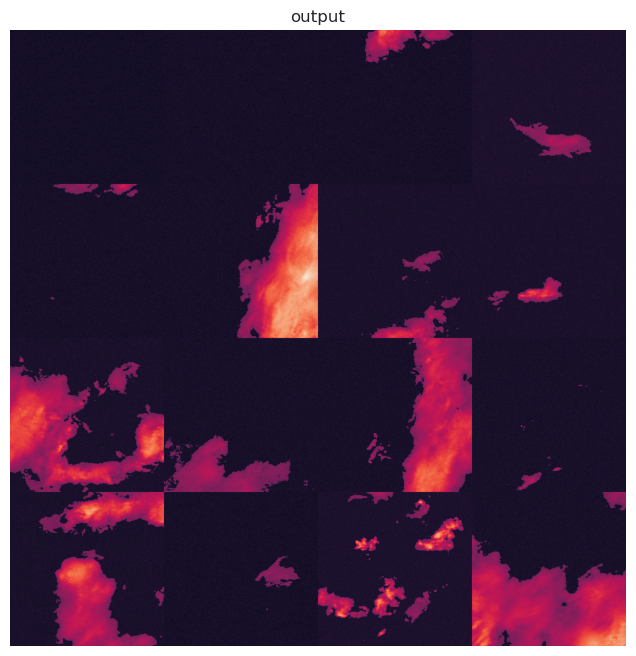

Output()

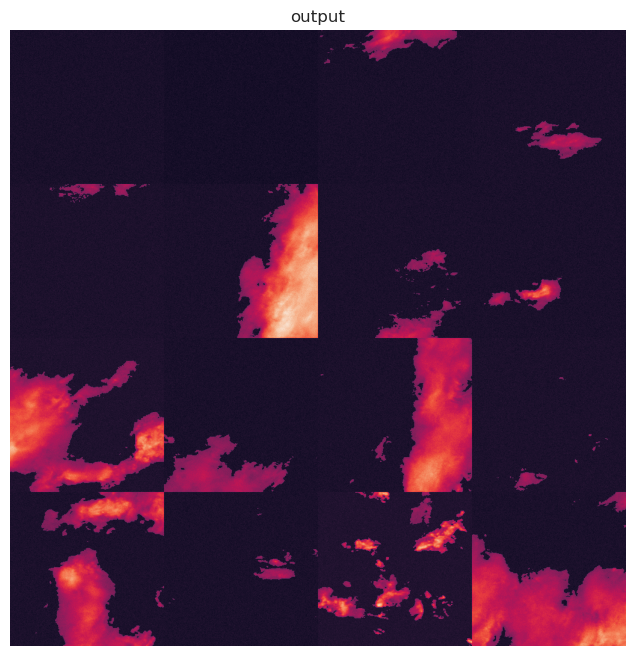

Output()

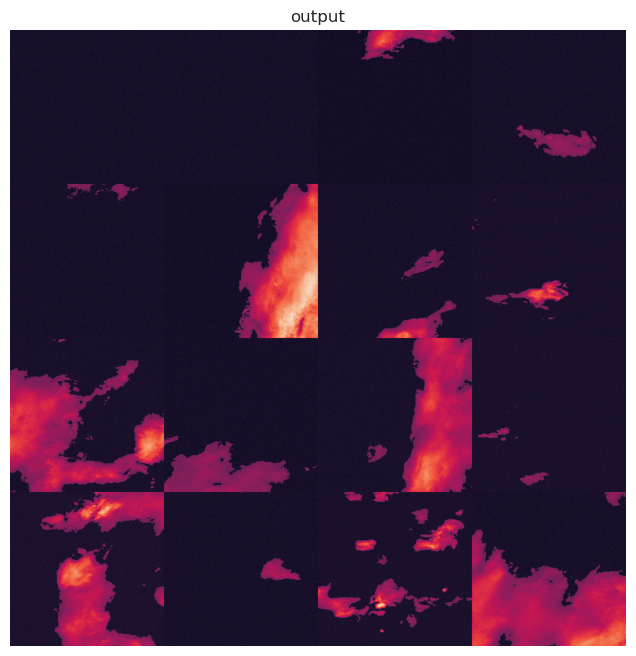

Output()

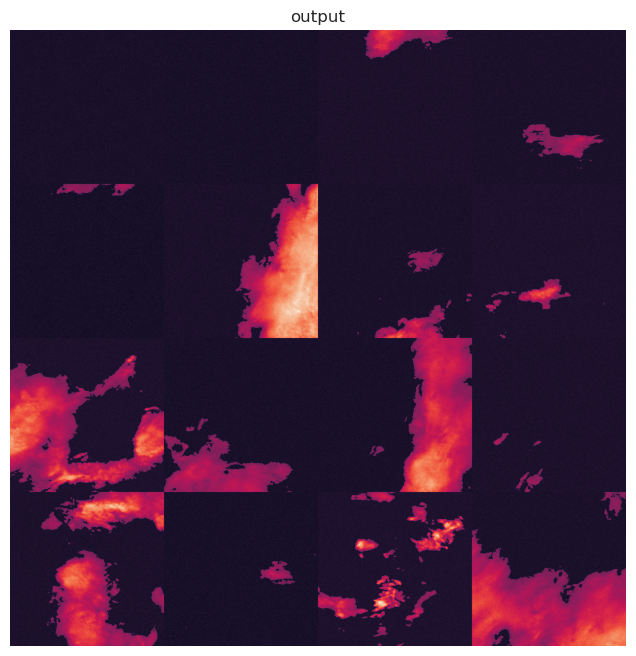

Output()

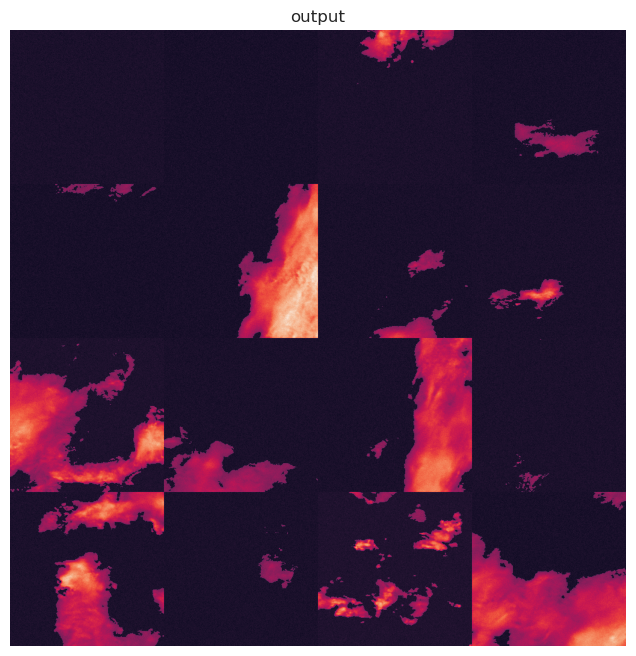

Output()

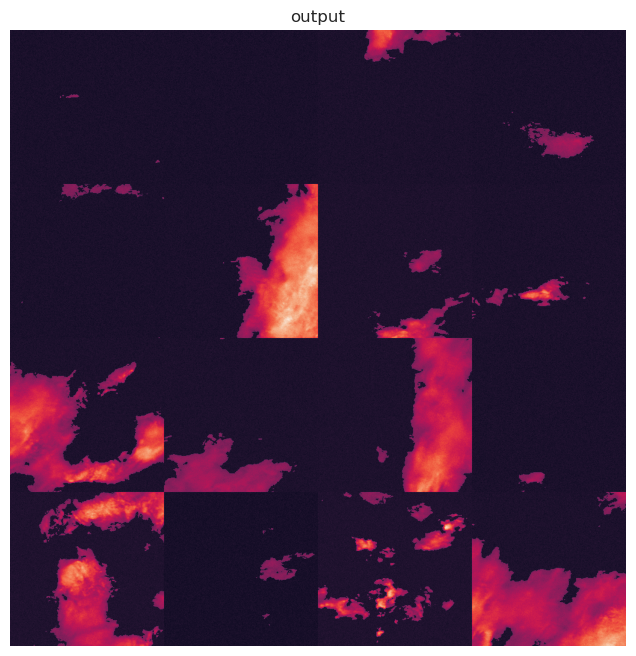

Output()

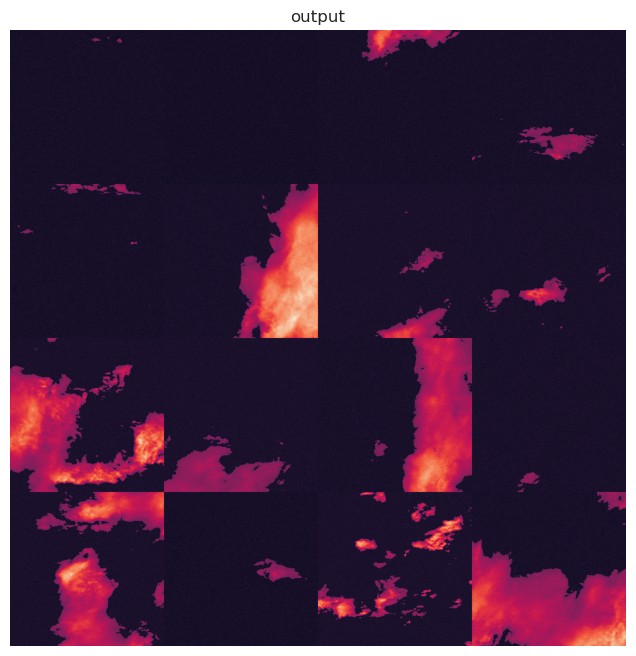

In [16]:
num_pred = 10
ensemble = []
for i in range(num_pred):
    x = pc_upsampler(score_model, scaler(low_res))
    show_samples(x, config=config, caption='output', save_path=f'./plt/emsemble_{i}.png')
    ensemble += []

In [13]:
ensemble

[]

## Compute per-pixel variance across the ensemble

## Does sample quality degrade with decreasing T?

In [10]:
iters = [100, 200, 500, 1000, 2000]
for iterations in iters:
    sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=iters)
    pc_upsampler = controllable_generation.get_pc_upsampler(sde,
                                                            predictor, corrector,
                                                            inverse_scaler,
                                                            snr=snr,
                                                            n_steps=n_steps,
                                                            probability_flow=probability_flow,
                                                            continuous=config.training.continuous,
                                                            denoise=True)
    x = pc_upsampler(score_model, scaler(low_res))
    show_samples(x, config=config, caption='output, N =', iterations)

SyntaxError: positional argument follows keyword argument (3685133328.py, line 13)